## Load the data

In [9]:
import json
import config
from transformers import AutoTokenizer, AutoModel
from matplotlib import pyplot as plt
import pickle
import numpy as np

In [10]:

vocab_params = config.VocabParameters()
training_params = config.TrainingParameters()
eval_params = config.EvalParameters()

with open(vocab_params.data_dir+ '/train.json') as infile:
    json_data = json.load(infile)
len(json_data)


68124

In [11]:
import pandas as pd
train_df = pd.DataFrame(json_data )
train_df_sorted = train_df.sort_values(by=['docid','id'], ascending = True)
train_df_sorted.head(5)

,id,docid,relation,token,subj_start,subj_end,obj_start,obj_end,subj_type,obj_type,stanford_pos,stanford_ner,stanford_head,stanford_deprel
42795,61b3a65fb960f284ebac,03c67d9ee4bf4ed33cbeddaa3a7b82cc,no_relation,"[Red, Sox, 12, ,, Athletics, 2]",0,1,4,4,ORGANIZATION,ORGANIZATION,"[NNP, NNP, CD, ,, NNP, CD]","[ORGANIZATION, ORGANIZATION, NUMBER, O, ORGANI...","[2, 0, 2, 2, 2, 5]","[compound, ROOT, nummod, punct, appos, nummod]"
46757,61b3a65fb9080a05b4ee,15df2fc6a9a895432237cb2bdfcbd1b5,no_relation,"[Thomas, ', assertion, of, 85, %, reporters, v...",41,43,31,31,ORGANIZATION,DATE,"[NNP, POS, NN, IN, CD, NN, NNS, VBP, JJ, VBZ, ...","[PERSON, O, O, O, PERCENT, PERCENT, O, O, MISC...","[3, 1, 8, 7, 6, 7, 3, 0, 12, 12, 12, 8, 12, 18...","[nmod:poss, case, nsubj, case, compound, amod,..."
36591,61b3a65fb9883fc52f01,274e368f381c1476fe0da7f201bfc331,no_relation,"[Kerry, did, his, duty, and, did, it, well, .]",2,2,0,0,PERSON,PERSON,"[NNP, VBD, PRP$, NN, CC, VBD, PRP, RB, .]","[PERSON, O, O, O, O, O, O, O, O]","[2, 0, 4, 2, 2, 2, 6, 6, 2]","[nsubj, ROOT, nmod:poss, dobj, cc, conj, dobj,..."
22262,61b3a65fb937b50fc05a,409fa10efff702a41701bdddab89a2dd,no_relation,"[This, August, ,, Moschella, 's, name, came, u...",17,20,39,40,ORGANIZATION,STATE_OR_PROVINCE,"[DT, NNP, ,, NNP, POS, NN, VBD, RP, IN, DT, NN...","[DATE, DATE, O, PERSON, O, O, O, O, O, O, O, O...","[2, 0, 2, 6, 4, 7, 2, 7, 11, 11, 7, 15, 15, 15...","[det, ROOT, punct, nmod:poss, case, nsubj, acl..."
644,61b3a5f2e85a8088c7bb,78d7e406b6911492f6f7f122d1f112ad,org:top_members/employees,"[Sharpton, is, president, of, the, National, A...",5,7,0,0,ORGANIZATION,PERSON,"[NNP, VBZ, NN, IN, DT, NNP, NNP, NNP, .]","[PERSON, O, O, O, O, ORGANIZATION, ORGANIZATIO...","[3, 3, 0, 8, 8, 8, 8, 3, 3]","[nsubj, cop, ROOT, case, det, compound, compou..."


## Create tokenizer for BIO BERT

In [12]:
tokenizer = AutoTokenizer.from_pretrained("gsarti/biobert-nli")

#### Helper function to convert work toekns to POS, NER and word vectors 

In [13]:
def addWord(word, pos, ner):
    """
    Convert a word into a word token and add supplied NER and POS labels. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, pos label, ner label
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc. 
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['posToken'] = [pos] + ['posX'] * (tokenLength - 1)
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    
    
    return addDict

### Convert the TACRED data to vectors using above helper method

In [14]:
"""
Read from above dataframe.  Each row in the dataframe represents a  
    
"""
max_length = 50
# lists for sentences, tokens, labels, etc.  
sentenceList = []
sentenceTokenList = []
posTokenList = []
nerTokenList = []
sentLengthList = []

# lists for BERT input
bertSentenceIDs = []
bertMasks = []
bertSequenceIDs = []

sentence = ''

# always start with [CLS] tokens
sentenceTokens = ['[CLS]']
posTokens = ['[posCLS]']
nerTokens = ['[nerCLS]']

pos_column = 'stanford_pos'
ner_column = 'stanford_ner'
token_column = 'token'


for ind in train_df.index:    
    word_list = train_df[token_column][ind]
    ner_list = train_df[ner_column][ind]
    pos_list = train_df[pos_column][ind]

    for i in range(0,len(word_list)):

        word = word_list[i]
        ner = ner_list[i]
        pos = pos_list[i]
        addDict = addWord(word, pos, ner)
    
        sentenceTokens += addDict['wordToken']
        posTokens += addDict['posToken']
        nerTokens += addDict['nerToken']        

#     print(sentenceTokens, posTokens, nerTokens, "\n")
    
    sentenceLength = min(max_length -1, len(sentenceTokens))
    sentLengthList.append(sentenceLength)
    
    # Create space for at least a final '[SEP]' token
    if sentenceLength >= max_length - 1: 
        sentenceTokens = sentenceTokens[:max_length - 2]
        posTokens = posTokens[:max_length - 2]
        nerTokens = nerTokens[:max_length - 2]

    # add a ['SEP'] token and padding

    sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))

    posTokens += ['[posSEP]'] + ['[posPAD]'] * (max_length - 1 - len(posTokens) )
    nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )

    sentenceList.append(sentence)

    sentenceTokenList.append(sentenceTokens)

    bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
    bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
    bertSequenceIDs.append([0] * (max_length))

    posTokenList.append(posTokens)
    nerTokenList.append(nerTokens)

    sentence = ''
    sentenceTokens = ['[CLS]']
    posTokens = ['[posCLS]']
    nerTokens = ['[nerCLS]']

    sentence += ' ' + word

# The first two list elements need to be removed. 1st line in file is a-typical, and 2nd line does not end a sentence   
sentLengthList = sentLengthList[2:]
sentenceTokenList = sentenceTokenList[2:]
bertSentenceIDs = bertSentenceIDs[2:]
bertMasks = bertMasks[2:]
bertSequenceIDs = bertSequenceIDs[2:]
posTokenList = posTokenList[2:]
nerTokenList = nerTokenList[2:]

(array([1.0000e+00, 1.8000e+01, 1.5000e+01, 4.1000e+01, 5.2000e+01,
        8.3000e+01, 1.0400e+02, 1.8400e+02, 1.8300e+02, 2.2500e+02,
        2.8800e+02, 2.8300e+02, 3.0700e+02, 4.2600e+02, 4.4500e+02,
        0.0000e+00, 4.9200e+02, 5.8300e+02, 6.6000e+02, 6.8500e+02,
        6.7700e+02, 7.3600e+02, 9.6100e+02, 9.5000e+02, 1.0360e+03,
        1.1930e+03, 1.2540e+03, 1.3570e+03, 1.3160e+03, 1.3940e+03,
        1.4160e+03, 0.0000e+00, 1.4130e+03, 1.5450e+03, 1.4980e+03,
        1.5340e+03, 1.6630e+03, 1.5620e+03, 1.5780e+03, 1.7290e+03,
        1.5580e+03, 1.5800e+03, 1.5840e+03, 1.5740e+03, 1.4380e+03,
        1.3910e+03, 1.4520e+03, 2.7658e+04]),
 array([ 4.    ,  4.9375,  5.875 ,  6.8125,  7.75  ,  8.6875,  9.625 ,
        10.5625, 11.5   , 12.4375, 13.375 , 14.3125, 15.25  , 16.1875,
        17.125 , 18.0625, 19.    , 19.9375, 20.875 , 21.8125, 22.75  ,
        23.6875, 24.625 , 25.5625, 26.5   , 27.4375, 28.375 , 29.3125,
        30.25  , 31.1875, 32.125 , 33.0625, 34.    , 34.93

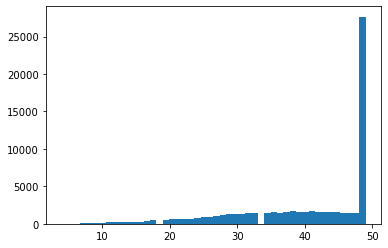

In [15]:
sentenceLengths= [l for l in sentLengthList]

plt.hist(np.array(sentenceLengths), bins=(max_length-2))

In [16]:
numSentences = len(bertSentenceIDs)

nerClasses = pd.DataFrame(np.array(nerTokenList).reshape(-1))
nerClasses.columns = ['tag']
nerClasses.tag = pd.Categorical(nerClasses.tag)
nerClasses['cat'] = nerClasses.tag.cat.codes
nerClasses['sym'] = nerClasses.tag.cat.codes
nerLabels = np.array(nerClasses.cat).reshape(numSentences, -1) 

In [17]:
x =nerClasses['tag'].unique()
x
for a in x:
    print(a)

[nerCLS]
O
ORGANIZATION
nerX
MISC
[nerSEP]
[nerPAD]
DATE
PERSON
NUMBER
LOCATION
ORDINAL
DURATION
SET
MONEY
TIME
PERCENT


In [18]:
nerDistribution = (nerClasses.groupby(['tag', 'cat']).agg({'sym':'count'}).reset_index()
                   .rename(columns={'sym':'occurences'}))

numNerClasses = nerDistribution.tag.nunique()

nerDistribution[nerDistribution['tag'] == 'O']

,tag,cat,occurences
102,O,0,0
103,O,1,0
104,O,2,0
105,O,3,0
106,O,4,0
107,O,5,0
108,O,6,1600623
109,O,7,0
110,O,8,0
111,O,9,0


### Now split data into train, test and dev

In [19]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])
numSentences = len(bert_inputs[0])
np.random.seed(0)
training_examples = np.random.binomial(1, 0.7, numSentences)

In [20]:
trainSentence_ids = []
trainMasks = []
trainSequence_ids = []

testSentence_ids = []
testMasks = []
testSequence_ids = []

nerLabels_train =[]
nerLabels_test = []


for example in range(numSentences):
    if training_examples[example] == 1:
        trainSentence_ids.append(bert_inputs[0][example])
        trainMasks.append(bert_inputs[1][example])
        trainSequence_ids.append(bert_inputs[2][example])
        nerLabels_train.append(nerLabels[example])
    else:
        testSentence_ids.append(bert_inputs[0][example])
        testMasks.append(bert_inputs[1][example])
        testSequence_ids.append(bert_inputs[2][example])
        nerLabels_test.append(nerLabels[example])
        
X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

nerLabels_train = np.array(nerLabels_train)
nerLabels_test = np.array(nerLabels_test)

In [21]:
X_train.shape

(3, 47758, 50)

In [22]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.

k_start = 0
k_end = -1

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_test = X_test[0].shape[0]
else:
    k_end_train = k_end_test = k_end
    


bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]


labels_train_k = nerLabels_train[k_start:k_end_train]
labels_test_k = nerLabels_test[k_start:k_end_test]

In [23]:
train_all = [bert_inputs_train_k, labels_train_k]
test_all = [bert_inputs_test_k, labels_test_k]

In [24]:
with open(r"./biobert_train_tacred_data.pickle", "wb") as output_file:
    pickle.dump(train_all, output_file)
    
with open(r"./biobert_test_tacred_data.pickle", "wb") as output_file:
    pickle.dump(test_all, output_file)

In [25]:
with open(r"./biobert_train_tacred_data.pickle", "rb") as input_file:
    bert_inputs_train_k, labels_train_k = train_all = pickle.load(input_file)
    
with open(r"./biobert_test_tacred_data.pickle", "rb") as input_file:
    bert_inputs_test_k, labels_test_k = test_all = pickle.load(input_file)

In [26]:
labels_train_k[8]

array([13, 10, 10,  6,  2,  2,  6,  6, 15, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
      dtype=int8)

In [76]:
np.array(bert_inputs_train_k).shape, labels_train_k.shape,np.array(bert_inputs_test_k).shape, labels_test_k.shape, 

((3, 47758, 50), (47758, 50), (3, 20364, 50), (20364, 50))

In [87]:
labels_train_k

array([[13,  6,  6, ..., 14, 14, 14],
       [13,  6,  6, ..., 14, 14, 14],
       [13,  6,  6, ..., 14, 14, 14],
       ...,
       [13,  6,  6, ..., 16, 15, 14],
       [13, 10, 16, ..., 14, 14, 14],
       [13,  6,  6, ..., 14, 14, 14]], dtype=int8)

## 

In [97]:
from torch import nn

# frozen_model = AutoModel.from_pretrained("gsarti/biobert-nli")
frozen_model = AutoModel.from_pretrained("bert-base-cased")

INFO:filelock:Lock 1970274510448 acquired on C:\Users\pnars/.cache\torch\transformers\d8f11f061e407be64c4d5d7867ee61d1465263e24085cfa26abf183fdc830569.3fadbea36527ae472139fe84cddaa65454d7429f12d543d80bfc3ad70de55ac2.lock


INFO:filelock:Lock 1970274510448 released on C:\Users\pnars/.cache\torch\transformers\d8f11f061e407be64c4d5d7867ee61d1465263e24085cfa26abf183fdc830569.3fadbea36527ae472139fe84cddaa65454d7429f12d543d80bfc3ad70de55ac2.lock


### Freeze the parameters

In [98]:
for param in frozen_model.parameters():
    param.requires_grad = False
    


In [99]:
from torch.utils.data import TensorDataset, RandomSampler

num_epochs=3
train_batch_size = 50

# Prepare data by processing features into inputs
all_input_ids = torch.tensor(bert_inputs_train_k[0], dtype=torch.long)
all_input_mask = torch.tensor(bert_inputs_train_k[1], dtype=torch.long)
all_segment_ids = torch.tensor(bert_inputs_train_k[2], dtype=torch.long)
all_label = torch.tensor(labels_train_k, dtype=torch.long)

# Package it all nicely into a TensorDataset 
train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label)

# Then package it into a DataLoader that can be batched and processed 
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size= train_batch_size)

global_step = 0
model.train()
for epoch in range(num_epochs):

  print("epoch", datetime.now(pytz.timezone('US/Pacific')).strftime("%Y%m%d_%H%M%S"))

  for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
    # Create a batch 
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids = batch

    # Calculate loss from forward feed method 
    output = model(input_ids=input_ids, 
                 attention_mask=input_mask, 
                 token_type_ids=segment_ids,
                 labels=label_ids,
                 return_dict=True)
    loss=output["loss"]

    # back prop
    loss.backward()

    if (step + 1) % args.gradient_accumulation_steps == 0:   # Number of updates steps to accumulate before performing a backward/update pass.
      # update 
      optimizer.step()
      # reset gradient 
      model.zero_grad()
      global_step += 1

      # Show the answer choice with the highest score for each question 
      train_predictions = torch.argmax(torch.nn.functional.softmax(output["logits"]), dim=1)
      # Accuracy against train data
      train_accuracy = float(sum(label_ids==train_predictions))/len(label_ids)

      # log loss 
      writer.add_scalar('training loss', 
                      loss.item(), 
                      global_step)
      # Log accuracy against train data
      writer.add_scalar('train accuracy', train_accuracy, global_step)

TypeError: __init__() got an unexpected keyword argument 'sampler'

## Using Custom Loss and accuracy functions

#### Define Custom Loss function for the NER Model and default loss function will include padded tokens

In [30]:
criterion = nn.CrossEntropyLoss() #For now, using simple loss function

def custom_loss(y_true, y_pred):
    """
    calculate loss function explicitly, filtering out 'extra inserted labels'
    
    y_true: Shape: (batch x (max_length + 1) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns:  cost
    """

    #get labels and predictions
    
    y_label = tf.reshape(Flatten()(tf.cast(y_true, tf.int32)),[-1])
    
    mask = (y_label < 13)   # This mask is used to remove all tokens that do not correspond to the original base text.

    y_label_masked = tf.boolean_mask(y_label, mask)  # mask the labels
    
    y_flat_pred = tf.reshape(Flatten()(tf.cast(y_pred, tf.float32)),[-1, numNerClasses])
    
    y_flat_pred_masked = tf.boolean_mask(y_flat_pred, mask) # mask the predictions
    
    return tf.reduce_mean(sparse_categorical_crossentropy(y_label_masked, y_flat_pred_masked,from_logits=False ))


#### Define Custom accuracy funciton

In [31]:
def calculate_accuracy(phase, running_loss, running_corrects):

    epoch_loss = running_loss / len(image_datasets[phase])
    epoch_acc = running_corrects.double() / len(image_datasets[phase])

    print('{} Loss: {:.4f} Acc: {:.4f}'.format( phase, epoch_loss, epoch_acc))
    
    return (epoch_loss, epoch_acc)


# def custom_acc_orig_tokens(y_true, y_pred):
#     """
#     calculate loss dfunction filtering out also the newly inserted labels
    
#     y_true: Shape: (batch x (max_length) )
#     y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
#     returns: accuracy
#     """

#     #get labels and predictions
    
#     y_label = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
#     mask = (y_label < 13)
#     y_label_masked = tf.boolean_mask(y_label, mask)
    
#     y_predicted = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
#                                                     [-1, numNerClasses]), axis=1)
    
#     y_predicted_masked = tf.boolean_mask(y_predicted, mask)

#     return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

### Define Otpimizer

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)

### Define learning rate scheduler

In [ ]:
from torch.optim import lr_scheduler

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, 
                                       step_size=7, 
                                       gamma=0.1)

#### Define the training phase
This will be the training operation performed at each epoch

* <b>scheduler.step()</b> will set up the scheduler for each step in order to decay the learning rate
* <b>model.train()</b> will set the pre-trained model into training mode. This is only available for pre-trained models
* <b>running_loss</b> will keep track of the loss at each iteration
* <b>running_corrects</b> keeps a count of the number of correct predictions which will be used to calculate the accuracy of the model
<br />
* By setting <b>torch.set_grad_enabled(True)</b> we are enabling Autograd
* <b>outputs</b> is the list probabilities for each possible label for the batch of images (which are the inputs). We use torch.max() to get the index of the highest probability label for each image in the batch

In [ ]:
def phase_train(model, criterion, optimizer, scheduler):
    
    scheduler.step()
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    
    for inputs, labels in dataloaders['train']:

        optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    calculate_accuracy('train', running_loss, running_corrects) 

#### Define the test phase
This will be the test operation performed at each epoch

* <b>model.eval()</b> will set the pre-trained model into evaluation mode. This is only available for pre-trained models
* <b>running_loss</b> will keep track of the loss at each iteration
* <b>running_corrects</b> keeps a count of the number of correct predictions which will be used to calculate the accuracy of the model
<br />
* By setting <b>torch.no_grad()</b> we are disabling Autograd
* <b>outputs</b> is the list probabilities for each possible label for the batch of images (which are the inputs). We use torch.max() to get the index of the highest probability label for each image in the batch
<br />

Once the accuracy is calculated, we check to see if the accuracy in this has improved since the previous epoch. If not, we do not adjust the weights of the model. If so, we set the weights of the model to be the ones calculated in this epoch and return those values

In [ ]:
def phase_test(model, criterion, optimizer):
    
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    global best_acc
    
    for inputs, labels in dataloaders['test']:

        optimizer.zero_grad()
        
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss, epoch_acc = calculate_accuracy('test', running_loss, running_corrects)
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
    return best_model_wts

#### We build upon our pre-trained model
* we initialize the <b>best_model_wts</b> from the weights of the pre-trained model
* perform the training and testing and update the model weights if it has supplied improved accuracy in the epoch

In [ ]:
def build_model(model, criterion, optimizer, scheduler, num_epochs=10):
    
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        phase_train(model, criterion, optimizer, scheduler)
        best_model_wts = phase_test(model, criterion, optimizer)
        print()
    
    print('Best test Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

#### Call the build_model function
We set the number of epochs to 1 here

In [ ]:
model = build_model(model, 
                    criterion, 
                    optimizer, 
                    exp_lr_scheduler, 
                    num_epochs=1)

#### Lets check how our model performs
We will take one batch from test datasets (and we have batches of 8 images) and we will predict the correct label


In [ ]:
with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    


In [27]:

model = AutoModel.from_pretrained("gsarti/biobert-nli")


In [28]:
import torch

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)


# Tokenized input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)

# Mask a token that we will try to predict back with `BertForMaskedLM`
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
# assert tokenized_text == ['[CLS]', 'who', 'was', 'jim', 'henson', '?', '[SEP]', 'jim', '[MASK]', 'was', 'a', 'puppet', '##eer', '[SEP]']

# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 0,1,1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])



In [29]:

model.eval()

# # If you have a GPU, put everything on cuda
# tokens_tensor = tokens_tensor.to('cuda')
# segments_tensors = segments_tensors.to('cuda')
# model.to('cuda')

# # model.to('cpu')
# # Predict hidden states features for each layer
# with torch.no_grad():
#     encoded_layers, _ = model(tokens_tensor, segments_tensors)

# encoded_layers

tensor([[[-0.4415,  0.4157,  0.4380,  ...,  0.2047,  0.5829,  1.1126],
         [-0.1455,  0.2898,  0.1529,  ...,  0.0967,  0.4842,  0.5950],
         [-0.1501,  0.2418, -0.0092,  ...,  0.1350,  0.7261,  0.8567],
         ...,
         [-0.4696,  0.3954,  0.2498,  ...,  0.1800,  0.4797,  0.6985],
         [-0.2440,  0.2130, -0.0440,  ...,  0.2516,  0.2903,  0.4101],
         [-0.4415,  0.4157,  0.4380,  ...,  0.2047,  0.5829,  1.1126]]],
       device='cuda:0')

In [ ]:
def phase_train(model, criterion, optimizer, scheduler):
    
    scheduler.step()
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    
    for inputs, labels in dataloaders['train']:

        optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(labels, outputs )
            
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    calculate_accuracy('train', running_loss, running_corrects) 